# AIN429 - Data Mining Laboratory
### Instructor: Suat Özdemir
### Assistant: Ahmet Alkılınç
### Subject: Frequent Pattern Mining
### Student Info: Can Ali Ateş
### Student ID: 2200765002

## Libraries & Dataset

In [ ]:
# Import necessary libraries.
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder

In [ ]:
# Read CSV file.
dataframe = pd.read_csv('data.csv')

# Get dimension information of dataframe.
print(f'Dataframe Shape: {dataframe.shape}')

# Display first 5 record of the dataframe.
dataframe.head()

Dataframe Shape: (38765, 3)


,Member_no,Date,item
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


## Data Preprocessing

In [ ]:
# Get feature's data type information of the dataframe.
dataframe.dtypes

Member_no     int64
Date         object
item         object
dtype: object

* **Member_no is an integer feature that contains the ID of member, so any integer preprocessing operation doesn't need for this feature.**
* **Date is an object feature that contains the purchased date of the item in dd-mm-yyyy format.**
* **item is an object feature that contains the name of the item.**

In [ ]:
# Get NaN value information of the dataframe.
dataframe.isna().sum()

Member_no    0
Date         0
item         0
dtype: int64

* **Dataset doesn't contain any NaN value, so I will not have any operation for handling NaN values.**

In [ ]:
# Strip object columns for possible whitespaces at the begginning and end.
dataframe['Date'].str.strip()
dataframe['item'].str.strip()

0               tropical fruit
1                   whole milk
2                    pip fruit
3             other vegetables
4                   whole milk
                 ...          
38760            sliced cheese
38761                    candy
38762                 cake bar
38763    fruit/vegetable juice
38764                 cat food
Name: item, Length: 38765, dtype: object

* **Date and item features can contain white spaces at the beggining and end, so strip operation get rid of from these possible whitespaces.**

In [ ]:
# Check consistency of Date feature.
date_consistent = True
for index in dataframe.index:
    day, month, year = dataframe['Date'].loc[index].split("-")
    if (0 <= int(year) <= 2022) and (1 <= int(month) <= 12) and (1 <= int(day) <= 31):
        data_consistent = False
        break
        
# Display consistency result.
print(f"Dates are {'consistent' if date_consistent else 'not consistent'}.")

Dates are consistent.


* **Day, month, and year values are checked based on the written format to take precautions before grouping operations.**

In [ ]:
# Group the purchased items according to year.
year_summarize = dataframe.groupby(dataframe['Date'].map(lambda x: x[-4:]))['item'].apply(list).to_frame()

# Display the summarization of each year.
year_summarize

,item
Date,
2014,"[rolls/buns, hamburger meat, turkey, specialty..."
2015,"[tropical fruit, whole milk, pip fruit, other ..."


* **As a result of the grouping, it is deduced that the data set was collected between the years 2014-2015.**

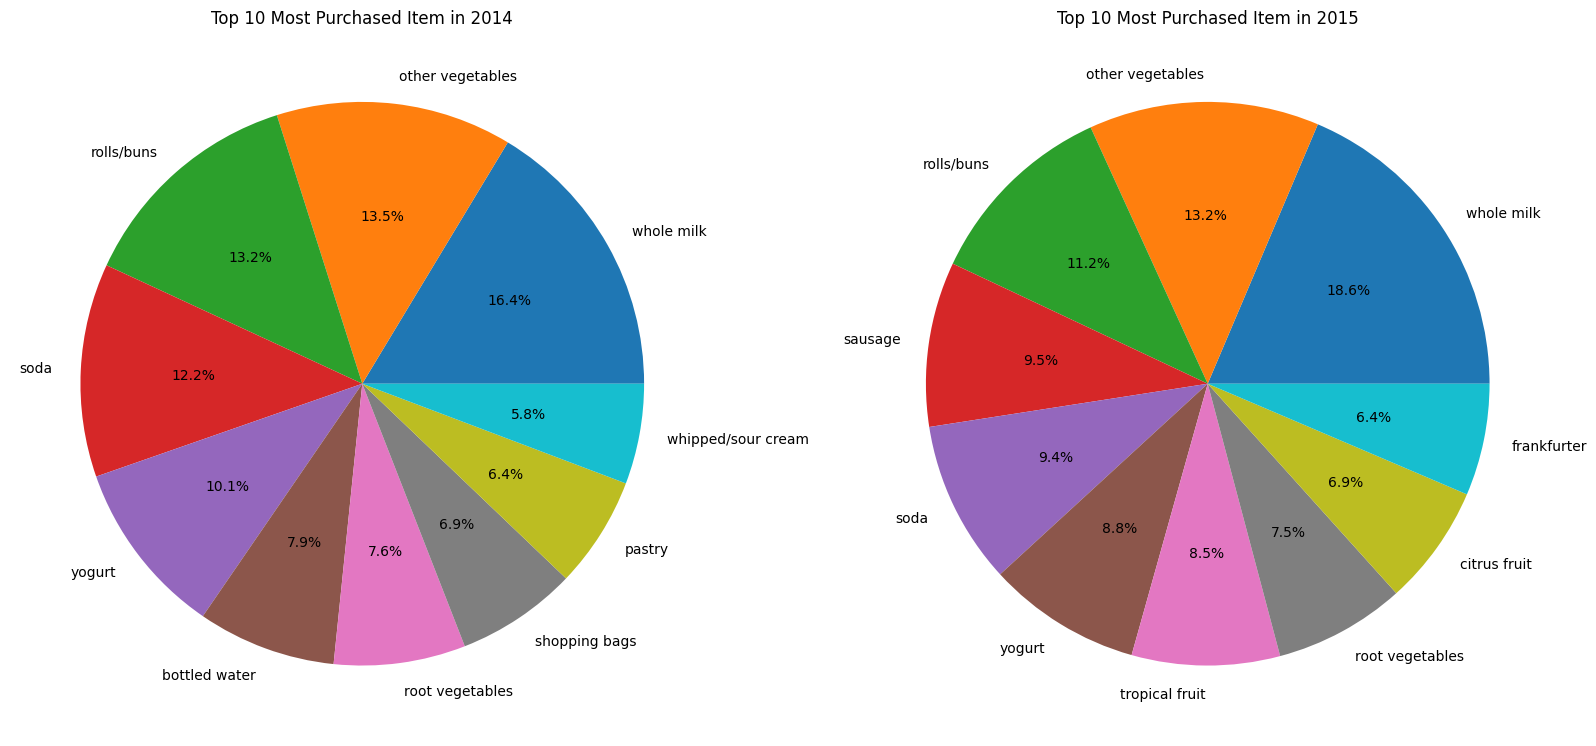

In [ ]:
# Count top 10 most purchased items of each year. 
year_2014 = Counter(year_summarize['item'][0]).most_common(10)
year_2015 = Counter(year_summarize['item'][1]).most_common(10)

# Create a subplot figure to plot pie chart of each year's top most 10 purchased items.
figure, axes = plt.subplots(1, 2, figsize=(20,12))

# Arrange labels and values for 2014.
labels_2014 = [item for item in [pair[0] for pair in year_2014]]
values_2014 = [count for count in [pair[1] for pair in year_2014]]
axes[0].pie(values_2014, labels = labels_2014, autopct = '%1.1f%%')
axes[0].set_title('Top 10 Most Purchased Item in 2014')

# Arrange labels and values for 2015.
labels_2015 = [item for item in [pair[0] for pair in year_2015]]
values_2015 = [count for count in [pair[1] for pair in year_2015]]
axes[1].pie(values_2015, labels = labels_2015, autopct = '%1.1f%%')
axes[1].set_title('Top 10 Most Purchased Item in 2015')

# Display the Pie Charts.
plt.show()

* **Pie Charts demonstrate the purchasing habits of people are changing each year, but people spend money on aliments mostly.**

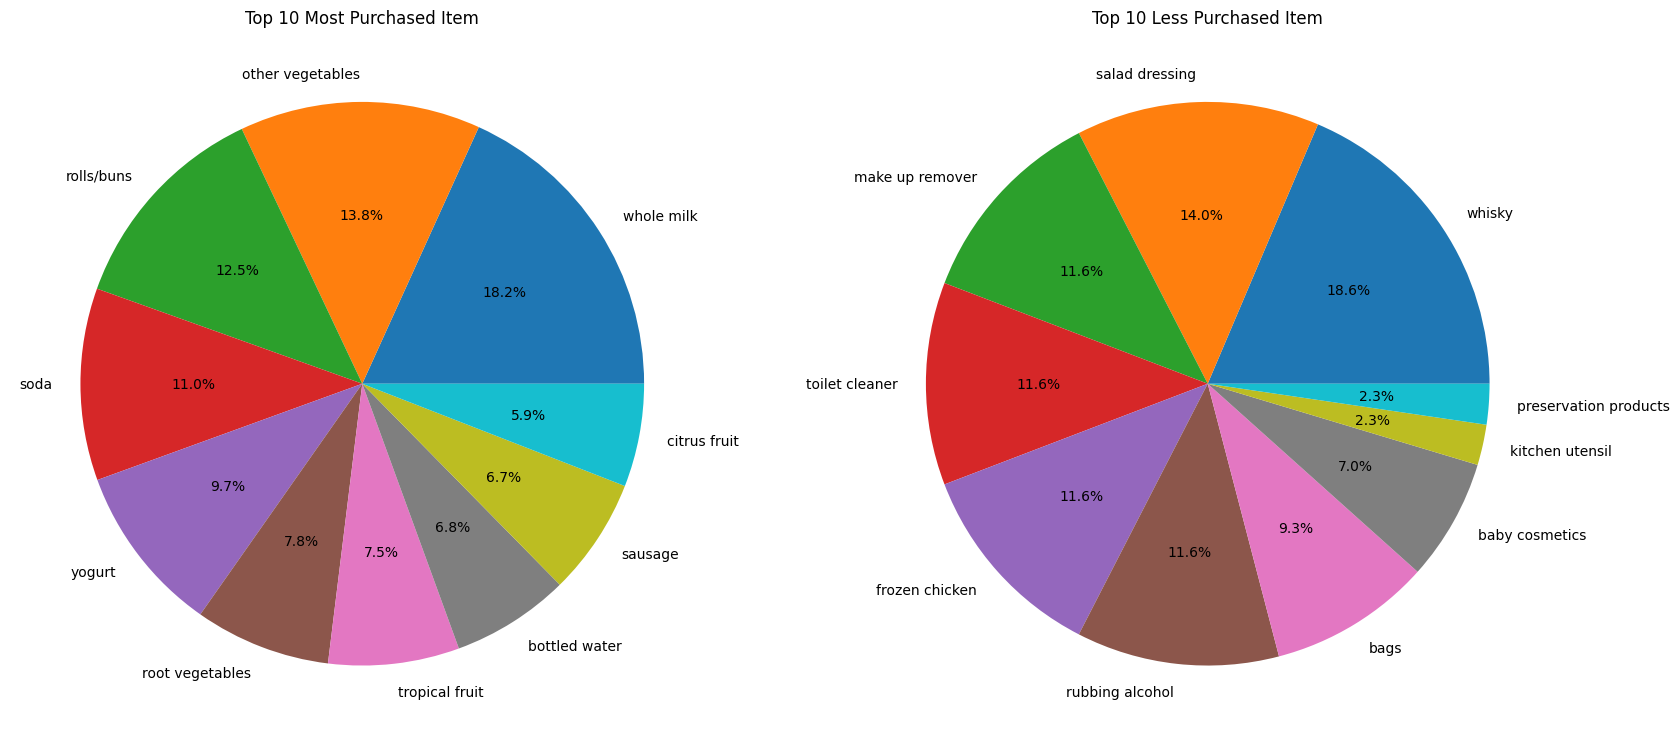

In [ ]:
# Get item frequencies.
item_frequencies = dataframe.item.value_counts()

# Create a subplot figure to plot pie chart of top most/less 10 purchased items.
figure, axes = plt.subplots(1, 2, figsize=(20,12))

# Arrange labels and values for top 10 most.
labels_most = item_frequencies.head(10).index
values_most = item_frequencies.head(10).values
axes[0].pie(values_most, labels = labels_most, autopct = '%1.1f%%')
axes[0].set_title('Top 10 Most Purchased Item')

# Arrange labels and values for top 10 less.
labels_less = item_frequencies.tail(10).index
values_less = item_frequencies.tail(10).values
axes[1].pie(values_less, labels = labels_less, autopct = '%1.1f%%')
axes[1].set_title('Top 10 Less Purchased Item')

# Display the Pie Charts.
plt.show()

* **Pie Charts demonstrate people prefer to spend money on aliments than personal needs.**

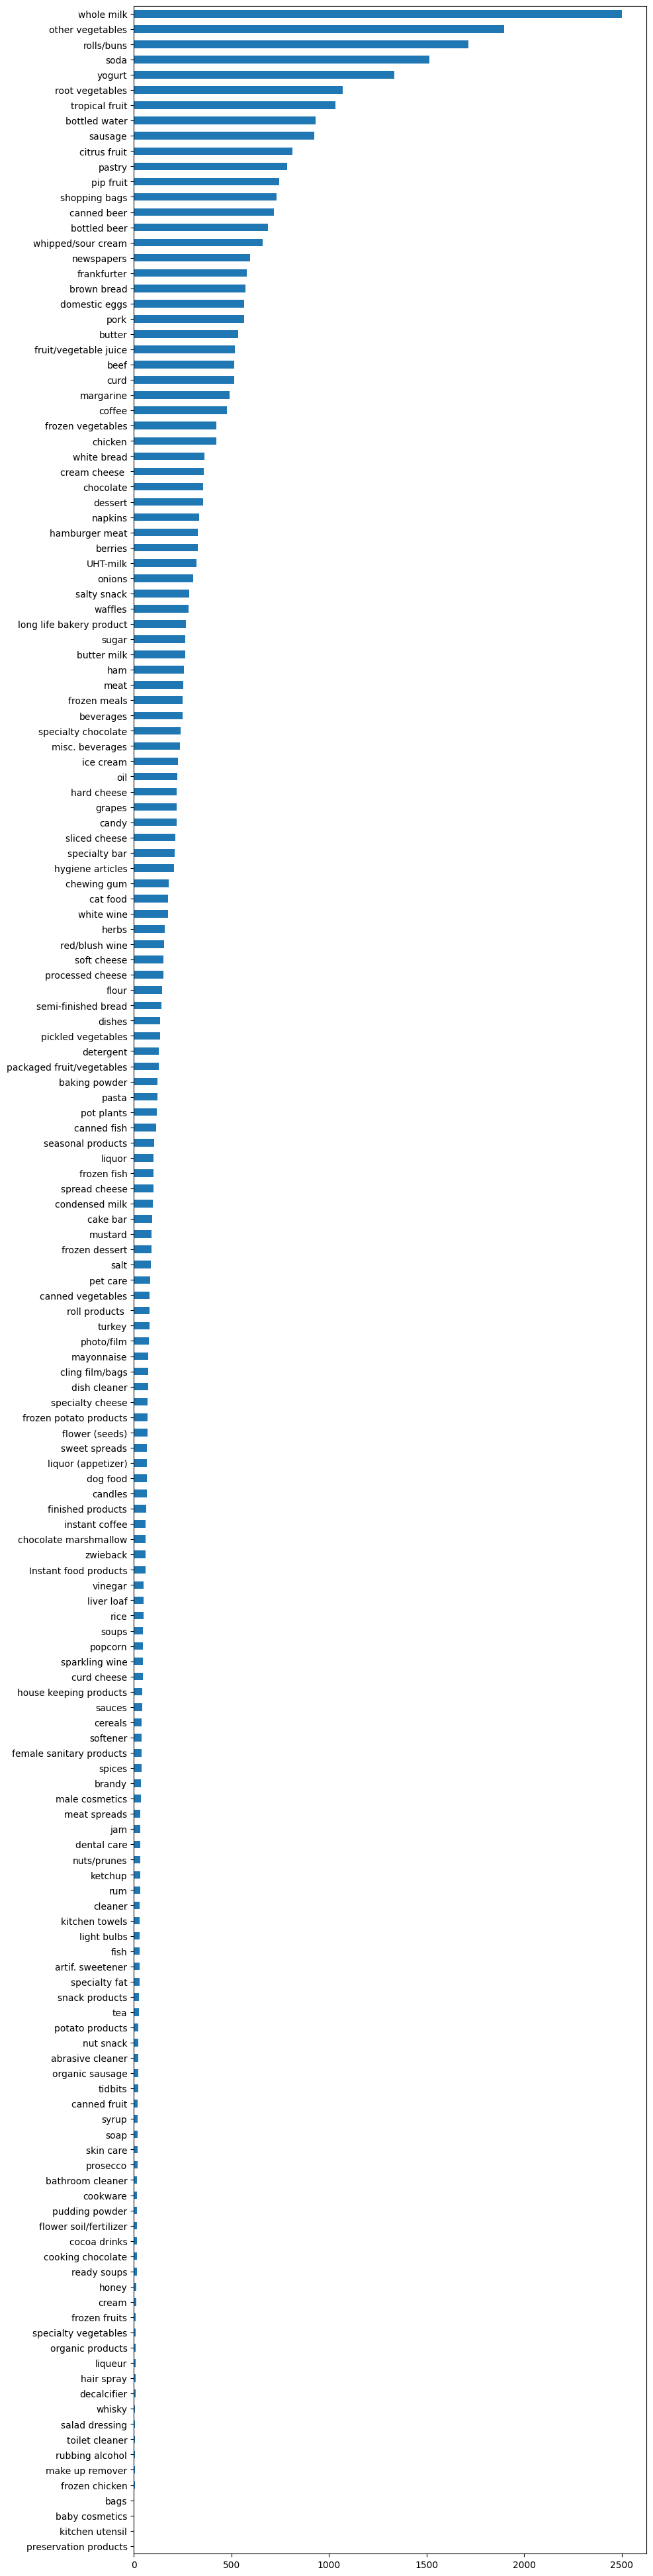

In [ ]:
# Display the item's frequency distribution.
item_frequencies.sort_values().plot(kind='barh', figsize = (10, 50))
plt.show()

* **The bar chart of how many times totally an item was purchased in 2014 and 2015 shows item types that are purchased more than 500 are too few, and most of the item types were purchased less than 500 times.**

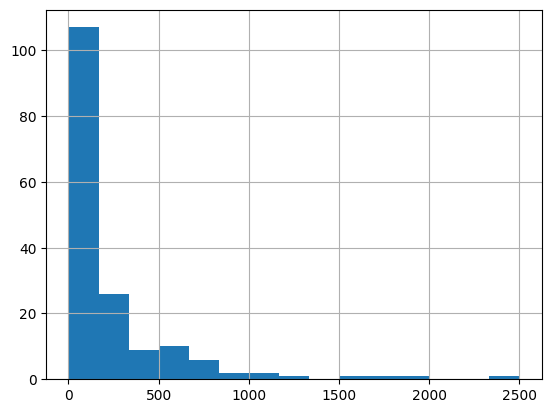

In [ ]:
# Display the item count's frequency distribution.
item_frequencies.hist(bins = 15)
plt.show()

* **The Histogram shows the distribution of how many times an item is purchased on the x-axis and how many different items are purchased for the specified count on the y-axis. According to the histogram result, item types that were purchased 500+ times are too few and most of the item types are purchased 0-500 times.** 

## Implementing Methods

### Preliminary Steps 

In [ ]:
# Group the dataframe according to purchase date of each member.
grouped_df = dataframe.groupby(['Member_no','Date'])['item'].apply(list).to_frame()

# Display the grouped dataframe.
grouped_df

item
Member_no Date                                                         
1000      15-03-2015  [sausage, whole milk, semi-finished bread, yog...
          24-06-2014                  [whole milk, pastry, salty snack]
          24-07-2015                     [canned beer, misc. beverages]
          25-11-2015                        [sausage, hygiene articles]
          27-05-2015                         [soda, pickled vegetables]
...                                                                 ...
4999      24-01-2015  [tropical fruit, berries, other vegetables, yo...
          26-12-2015                             [bottled water, herbs]
5000      09-03-2014                    [fruit/vegetable juice, onions]
          10-02-2015       [soda, root vegetables, semi-finished bread]
          16-11-2014                   [bottled beer, other vegetables]

[14963 rows x 1 columns]

* **Grouping the dataframe based on Member_no and Date provides creating the purchased item lists of a member for each day.**

In [ ]:
# Create a list from item feature of grouped dataframe which contains the list of items taken in same day.
purchase_lists = grouped_df['item'].tolist()

# Display the first 5 elements of created list.
purchase_lists[:5]

[['sausage', 'whole milk', 'semi-finished bread', 'yogurt'],
 ['whole milk', 'pastry', 'salty snack'],
 ['canned beer', 'misc. beverages'],
 ['sausage', 'hygiene articles'],
 ['soda', 'pickled vegetables']]

* **Member_no and Date are not necessary for frequent pattern mining, so put the item lists into a list and create a nested list structure.**

In [ ]:
# Apply bit-mapping to list of purchased item lists.
transaction_encoder = TransactionEncoder()
transaction_array = transaction_encoder.fit(purchase_lists).transform(purchase_lists)

# Convert the bit-mapping result into dataframe.
items_df = pd.DataFrame(transaction_array, columns = transaction_encoder.columns_)
items_df

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
14959,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14960,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14961,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


* **Applying bit-map encoding to each list, creates a dataframe that shows which list contains which items.**

In [ ]:
# Change Pandas displaying option to visualize all rows at the same time.
pd.set_option('display.max_rows', None)

### Apriori Algorithm

In [ ]:
# Implement and apply the Apriori Algorithm.
apriori(items_df, min_support=0.01, use_colnames=True)

,support,itemsets
0,0.021386,(UHT-milk)
1,0.033950,(beef)
2,0.021787,(berries)
3,0.016574,(beverages)
4,0.045312,(bottled beer)
5,0.060683,(bottled water)
6,0.037626,(brown bread)
7,0.035220,(butter)
8,0.017577,(butter milk)
9,0.014369,(candy)


* **Apriori Algorithm finds 64 frequent 1-itemset and 5 frequent 2-itemset. As expected from the pie chart analysis, frequent 2-itemsets are contains the most purchased items.**

### FP Growth Algorithm

In [ ]:
# Implement and apply the FP Growth Algorithm.
fpgrowth(items_df, min_support=0.01, use_colnames=True)

,support,itemsets
0,0.157923,(whole milk)
1,0.085879,(yogurt)
2,0.060349,(sausage)
3,0.051728,(pastry)
4,0.018780,(salty snack)
5,0.046916,(canned beer)
6,0.015772,(misc. beverages)
7,0.013700,(hygiene articles)
8,0.097106,(soda)
9,0.037760,(frankfurter)


* **FP Growth Algorithm finds 64 frequent 1-itemset and 5 frequent 2-itemset. As expected from the pie chart analysis, frequent 2-itemsets are contains the most purchased items. Order of the found itemsets are different from Apriori because of the BFS and DFS Algorithms properties.**

### Comparison of Algorithms

In [ ]:
# Evaluate the Apriori Algorithm.
print('Apriori Performance: ', end = '')
apriori_result = %timeit -n 100 -r 10 -o apriori(items_df, min_support=0.01, use_colnames=True)

Apriori Performance: 139 ms ± 15 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [ ]:
# Evaluate the FP Growth Algorithm.
print('FPGrowth Performance: ', end = '')
fpgrowth_result = %timeit -n 100 -r 10 -o fpgrowth(items_df, min_support=0.01, use_colnames=True)

FPGrowth Performance: 61.1 ms ± 1.15 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


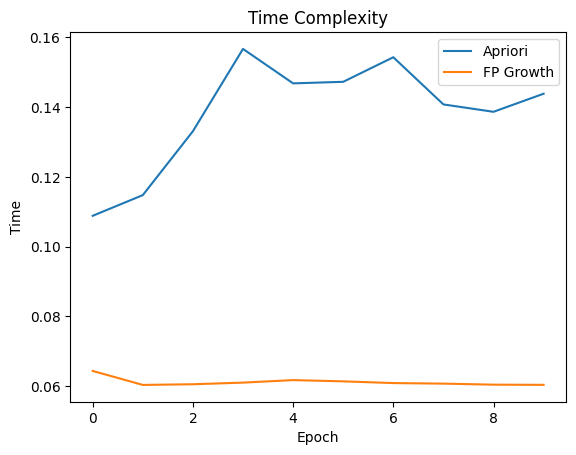

In [ ]:
# Get timing performance of Apriori and FP Growth Algorithms.
apriori_timings = vars(apriori_result).get('timings')
fpgrowth_timings = vars(fpgrowth_result).get('timings')

# Plot a single graph to compare algorithms.
plt.plot(apriori_timings)
plt.plot(fpgrowth_timings)
plt.title('Time Complexity')
plt.ylabel('Time')
plt.xlabel('Epoch')
plt.legend(['Apriori', 'FP Growth'])
plt.show()

* **FP Growth works more faster and stable than Apriori Algorithm because FP Growth uses DFS and Apriori uses BFS. In the larger datasets, FP Growth has the advantage to reach deep frequent patterns because of this property. In the experiment; FP Growth works approximately 2 times faster than Apriori, and Apriori has a bigger standard deviation than FP Growth. As shown in the graph; while Apriori fluctuates and is not stable because of high standard deviation, FP Growth mostly works stable.**

## Report

### Overview of Problem
**Frequent Pattern Mining is an analytical process to find repetitive patterns, associations, or casual structures of the datasets. Apriori and FP Growth are popular methods for frequent pattern mining. In this problem, we observed these methods' performance.**

### Dataset
**The dataset contains 38765 records and 3 features which are Member No, Date, and Item Name. While Member No is an integer column, Date and Item Name features are object columns.**

### Date Preprocessing & Analyze
1. **I checked the dataset for NaN values, but the dataset doesn't contain any NaN value; so I will not strive for filling in missing values or any operation about NaN value handling**
2. **I applied a strip operation to get rid of the possible white spaces at the beginning or end of object columns. Member No is an integer column so doesn't need to strip operation.**
3. **I checked the consistency of Date feature based on day, month and year values and format; Date feature is consistent based on the results so doesn't need any operation for correction.**
4. **I grouped the items which are purchased in related years based on years, with the benefit of the Date feature. As a result of the grouping operation, I reached the information that the data was collected between the years 2014-2015.**
5. **I visualized the top 10 most purchased items for each year as a pie chart with percentages. These pie charts showed me the purchasing habits of people are changing year by year.**
6. **I counted the items in the main dataset to analyze generally the purchasing habits of people. I visualized the top 10 most/less purchased items of people with pie charts. These pie charts created a hypothesis that people spend more money on aliments than on personal needs.**
7. **I plotted a bar chart with each item's count to prove that hypothesis. Based on the bar chart results from most purchased to less; while the aliments are reducing, the personal needs are increasing.**
8. **I plotted a histogram to observe the number of products by number of purchase distribution. This histogram demonstrated the number of products which are purchased 1000+ time is too few, and most of the products purchased 0-500 times.**

### Implementing Frequent Pattern Mining Methods
1. **I grouped the main dataframe firstly based on Member No feature, then group this grouped dataframe based on the Date feature. As a result of these grouping operations, I created a dataframe that holds the list of purchased items by each member by day.**
2. **I get the lists from grouped dataframe, because member no and date features will no longer work for the frequent pattern mining methods. Then, I put these lists into a list to use each list as an element for frequent pattern mining.**
3. **I applied bit-map encoding to that nested list structure, this encoding creates a dataframe that shows which list contains which items.**
4. **I implemented an Apriori Algorithm with min_sup = 0.01, then apply this algorithm to bit-map encoded dataframe. The algorithm returned another dataframe, which shows the frequent items.**
5. **I implemented an FP Growth Algorithm with min_sup = 0.01, then apply this algorithm to bit-map encoded dataframe. The algorithm returned another dataframe which shows the frequent items.**

### Analyzing Apriori and FP Growth
1. **As an expert knowledge; while Apriori is a Breadth-First Search Algorithm, FP Growth is a Depth-First Search Algorithm. So, theoretically, FP Growth works faster than Apriori for larger datasets but uses more memory if the frequent pattern contains many items because it creates an FP tree for all possible frequent patterns.**
2. **In the experiment; Apriori and FP Growth find frequent items in different order, which shows the Breadth-First Search and Depth-First Search impact.**
3. **In the experiment; based on 100 loops with 10 epochs, FP Growth works approximately x2 times faster than Apriori as expected from theoretical knowledge. That difference causes because by Depth-First Search and Breadth-First Search working analogy. Also, the standard deviation of Apriori is more than FP Growth; that creates a hypothesis that indicates the line graph of Apriori will more fluctuate than FP Growth.**
4. **Visualization of running times in each epoch of Apriori and FP Growth shows FP Growth worked faster for all epochs. Based on the line shapes, Apriori fluctuates more in epoch transitions; these fluctuations infer the FP Growth works more stable than Apriori as expected in the written results part.**